In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

c:\Users\BeiFeng\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:

df = pd.read_csv('train/weather.csv')[['date', 'OT']]  # 因为我的数据有多列，在这里我给这两列进行的单独提取出来
df.head(2)

C:\Users\BeiFeng\AppData\Local\Temp\ipykernel_26000\3513149933.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train/weather.csv')[['date', 'OT']]  # 因为我的数据有多列，在这里我给这两列进行的单独提取出来


,date,OT
0,2020-01-01 00:10:00,428.1
1,2020-01-01 00:20:00,428.0


In [3]:
# 初始化标准化器
scaler = StandardScaler()
cols_data = df.columns[1:]
df_data = df[cols_data]
scaler.fit(df_data.values)
data_scaled = scaler.transform(df_data.values)

In [4]:
# 将时间列转换为 DataFrame
df_time = pd.DataFrame(df['date'])  # 假设时间列名为'date'
df_scaled_with_time = pd.concat([df_time, pd.DataFrame(data_scaled, columns=cols_data)], axis=1)

In [5]:
l = int(len(df)*0.2)
train = df_scaled_with_time[:-l]
test = df_scaled_with_time[-l:]
len(test)

10337

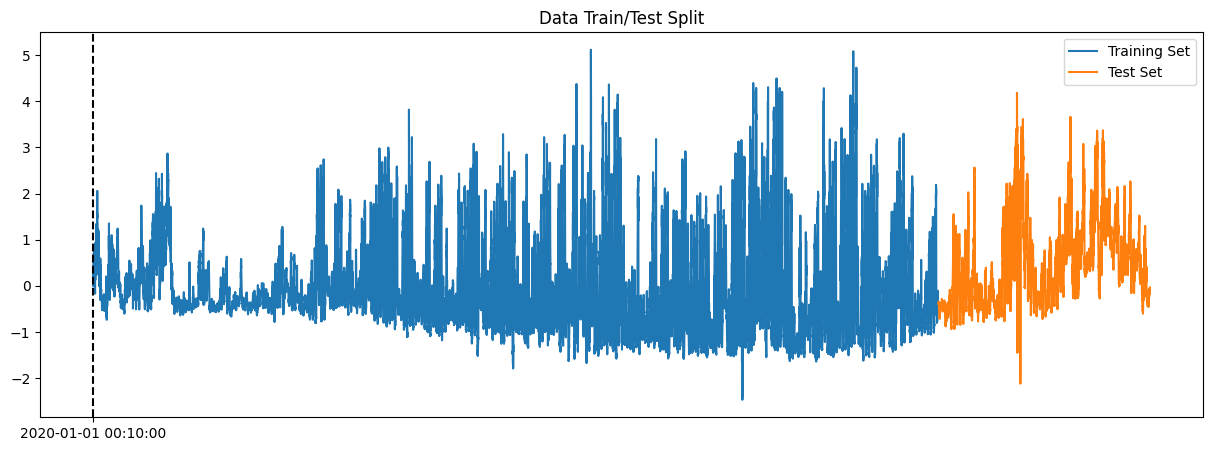

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2020-01-01 00:10:00', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [7]:
# 这里需要将你的时间列和数据列进行重命名因为Prophet需要的两列名字固定是ds 和 y
train.rename(columns={'date': 'ds', 'OT': 'y'}, inplace=True)
test.rename(columns={'date': 'ds', 'OT': 'y'}, inplace=True)

C:\Users\BeiFeng\AppData\Local\Temp\ipykernel_26000\3054937913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename(columns={'date': 'ds', 'OT': 'y'}, inplace=True)
C:\Users\BeiFeng\AppData\Local\Temp\ipykernel_26000\3054937913.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.rename(columns={'date': 'ds', 'OT': 'y'}, inplace=True)


In [8]:
# 初始化Prophet模型
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
# 拟合模型
model.fit(train)

18:12:31 - cmdstanpy - INFO - Chain [1] start processing
18:12:55 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# 创建未来日期的数据框
future = model.make_future_dataframe(periods=l, freq='10min')

In [15]:
# 进行预测
forecast = model.predict(future)

In [16]:
forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01 00:10:00,0.415620,-0.097630,1.709065,0.415620,0.415620,0.408122,0.408122,0.408122,0.321514,...,0.017658,0.017658,0.017658,0.068950,0.068950,0.068950,0.0,0.0,0.0,0.823742
1,2020-01-01 00:20:00,0.415591,-0.011976,1.755444,0.415591,0.415591,0.437733,0.437733,0.437733,0.351869,...,0.017817,0.017817,0.017817,0.068047,0.068047,0.068047,0.0,0.0,0.0,0.853324


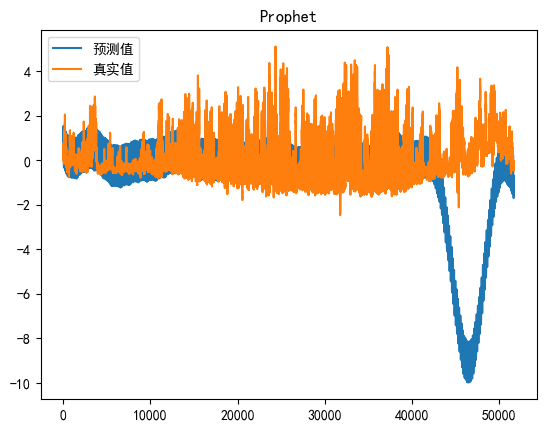

In [17]:
plt.rcParams['font.sans-serif'] = ['Kaitt', 'SimHei']
plt.figure()
plt.plot(forecast['yhat'], label='预测值')
plt.plot(df_scaled_with_time['OT'], label='真实值')
plt.title('Prophet')
plt.legend()
plt.rcParams['axes.unicode_minus'] = False
plt.show()

In [18]:
from metrics import metric
# 计算MSE和MAE
mae, mse, rmse, mape, mspe = metric(forecast['yhat'], test['y'])
# test_mse = mean_squared_error(test_result['y'], test_result['yhat'])
# test_mae = mean_absolute_error(test_result['y'], test_result['yhat'])

print(f"验证集 MSE: {mse}, MAE: {mae}")
# print(f"测试集 MSE: {test_mse}, MAE: {test_mae}")

验证集 MSE: 30.70197627262318, MAE: 4.294036900387796
